In [1]:
import numpy as np
import pandas as pd
from tabulate import tabulate
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

In [2]:


class DPSKProcess:
    def __init__(self, bits, samples_per_bit=50, carrier_freq=10):
        self.input_bits = np.array(bits)
        self.time = np.arange(len(bits))
        self.samples_per_bit = samples_per_bit
        self.carrier_freq = carrier_freq
        self.total_samples = len(bits) * samples_per_bit
        self.t = np.linspace(0, len(bits), self.total_samples)

    def generate_signals(self, results):
        """Generate all DPSK signals"""
        # Initialize signals
        baseband = np.zeros(self.total_samples)
        modulated = np.zeros(self.total_samples)
        carrier = np.cos(2 * np.pi * self.carrier_freq * self.t)

        # Generate baseband and modulated signals
        for i in range(len(self.input_bits)):
            start = i * self.samples_per_bit
            end = (i + 1) * self.samples_per_bit

            # Baseband signal (line coding)
            baseband[start:end] = results['line_code'][i]

            # Modulated signal
            phase = results['theta_k'][i]
            modulated[start:end] = np.cos(2 * np.pi * self.carrier_freq * self.t[start:end] + phase)

        return baseband, modulated, carrier

    def process_dpsk(self):
        # Initialize arrays
        N = len(self.input_bits)
        q_k = np.zeros(N, dtype=int)
        line_code = np.zeros(N, dtype=int)
        theta_k = np.zeros(N, dtype=float)
        theta_diff = np.zeros(N, dtype=float)
        detected_bits = np.zeros(N, dtype=int)

        # Set initial conditions
        q_k[0] = 0
        line_code[0] = -1
        theta_k[0] = np.pi

        # Process DPSK encoding
        for k in range(1, N):
            q_k[k] = self.input_bits[k-1] ^ q_k[k-1]
            line_code[k] = 1 if q_k[k] == 1 else -1
            theta_k[k] = 0 if line_code[k] == 1 else np.pi
            theta_diff[k] = (theta_k[k] - theta_k[k-1]) % (2*np.pi)
            if theta_diff[k] > np.pi:
                theta_diff[k] = theta_diff[k] - 2*np.pi

        # DPSK detection
        detected_bits[0] = self.input_bits[0]
        for k in range(1, N):
            if abs(theta_diff[k]) < np.pi/2:
                detected_bits[k] = 1
            else:
                detected_bits[k] = 0

        results = {
            'time': self.time,
            'input_bits': self.input_bits,
            'q_k': q_k,
            'line_code': line_code,
            'theta_k': theta_k,
            'theta_diff': theta_diff,
            'detected_bits': detected_bits
        }

        # Generate signals
        baseband, modulated, carrier = self.generate_signals(results)
        results['baseband'] = baseband
        results['modulated'] = modulated
        results['carrier'] = carrier
        results['t'] = self.t

        return results

    def plot_signals(self, results):
        """Plot all signals and constellation"""
        fig = plt.figure(figsize=(15, 12))
        gs = GridSpec(5, 2, figure=fig)

        # Input bits
        ax1 = fig.add_subplot(gs[0, :])
        ax1.stem(results['time'], results['input_bits'], basefmt=' ')
        ax1.set_title('Input Bits')
        ax1.grid(True)
        ax1.set_ylabel('Amplitude')

        # Baseband signal
        ax2 = fig.add_subplot(gs[1, :])
        ax2.plot(results['t'], results['baseband'])
        ax2.set_title('Baseband Signal (Line Coding)')
        ax2.grid(True)
        ax2.set_ylabel('Amplitude')

        # Carrier signal (partial)
        ax3 = fig.add_subplot(gs[2, :])
        # Show only first two bit periods for carrier clarity
        show_samples = 2 * self.samples_per_bit
        ax3.plot(results['t'][:show_samples], results['carrier'][:show_samples])
        ax3.set_title('Carrier Signal (First Two Bits)')
        ax3.grid(True)
        ax3.set_ylabel('Amplitude')

        # Modulated signal
        ax4 = fig.add_subplot(gs[3, :])
        ax4.plot(results['t'], results['modulated'])
        ax4.set_title('DPSK Modulated Signal')
        ax4.grid(True)
        ax4.set_ylabel('Amplitude')
        ax4.set_xlabel('Time')

        # Constellation diagram
        ax5 = fig.add_subplot(gs[4, 0])
        self.plot_constellation(results, ax5)

        # Phase transitions
        ax6 = fig.add_subplot(gs[4, 1])
        self.plot_phase_transitions(results, ax6)

        plt.tight_layout()
        return fig

    def plot_constellation(self, results, ax):
        """Plot constellation diagram"""
        # Sample points at symbol centers
        I = np.cos(results['theta_k'])
        Q = np.sin(results['theta_k'])

        # Plot constellation points
        ax.scatter(I, Q, c='blue', label='Symbol Points')

        # Plot unit circle
        circle = plt.Circle((0, 0), 1, fill=False, color='gray', linestyle='--')
        ax.add_artist(circle)

        # Add arrows for transitions
        for i in range(len(I)-1):
            ax.arrow(I[i], Q[i], (I[i+1]-I[i])*0.4, (Q[i+1]-Q[i])*0.4,
                    head_width=0.05, head_length=0.1, fc='red', ec='red', alpha=0.3)

        ax.grid(True)
        ax.set_title('Constellation Diagram')
        ax.set_xlabel('In-Phase')
        ax.set_ylabel('Quadrature')
        ax.set_xlim([-1.5, 1.5])
        ax.set_ylim([-1.5, 1.5])
        ax.axis('equal')

    def plot_phase_transitions(self, results, ax):
        """Plot phase transitions"""
        ax.plot(results['time'], results['theta_k']/np.pi, 'bo-', label='Phase')
        ax.set_title('Phase Transitions')
        ax.set_ylabel('Phase (π radians)')
        ax.set_xlabel('Symbol Index')
        ax.grid(True)
        ax.set_ylim([-0.5, 1.5])

    def display_results(self, results):
        # Convert phases to multiples of π
        theta_k_pi = [f"{x/np.pi:.0f}π" if x != 0 else "0" for x in results['theta_k']]
        theta_diff_pi = [f"{x/np.pi:.0f}π" if x != 0 else "0" for x in results['theta_diff']]

        # Create DataFrame
        df = pd.DataFrame({
            'k': results['time'],
            'I_k': results['input_bits'],
            'q_k': results['q_k'],
            'a_k': results['line_code'],
            'θ_k': theta_k_pi,
            'θ_k-θ_(k-1)': theta_diff_pi,
            'Detected bits': results['detected_bits']
        })

        # Print table
        print("\nDPSK Encoding and Detection Process:")
        print(tabulate(df, headers='keys', tablefmt='grid', showindex=False))

        # Verify detection
        errors = np.sum(results['input_bits'] != results['detected_bits'])
        print(f"\nNumber of detection errors: {errors}")
        if errors == 0:
            print("Perfect detection achieved!")
        else:
            print("Warning: Some bits were not correctly detected!")




DPSK Encoding and Detection Process:
+-----+-------+-------+-------+-------+---------------+-----------------+
|   k |   I_k |   q_k |   a_k | θ_k   | θ_k-θ_(k-1)   |   Detected bits |
+=====+=======+=======+=======+=======+===============+=================+
|   0 |     1 |     0 |    -1 | 1π    | 0             |               1 |
+-----+-------+-------+-------+-------+---------------+-----------------+
|   1 |     0 |     1 |     1 | 0     | 1π            |               0 |
+-----+-------+-------+-------+-------+---------------+-----------------+
|   2 |     1 |     1 |     1 | 0     | 0             |               1 |
+-----+-------+-------+-------+-------+---------------+-----------------+
|   3 |     0 |     0 |    -1 | 1π    | 1π            |               0 |
+-----+-------+-------+-------+-------+---------------+-----------------+
|   4 |     0 |     0 |    -1 | 1π    | 0             |               1 |
+-----+-------+-------+-------+-------+---------------+-----------------+


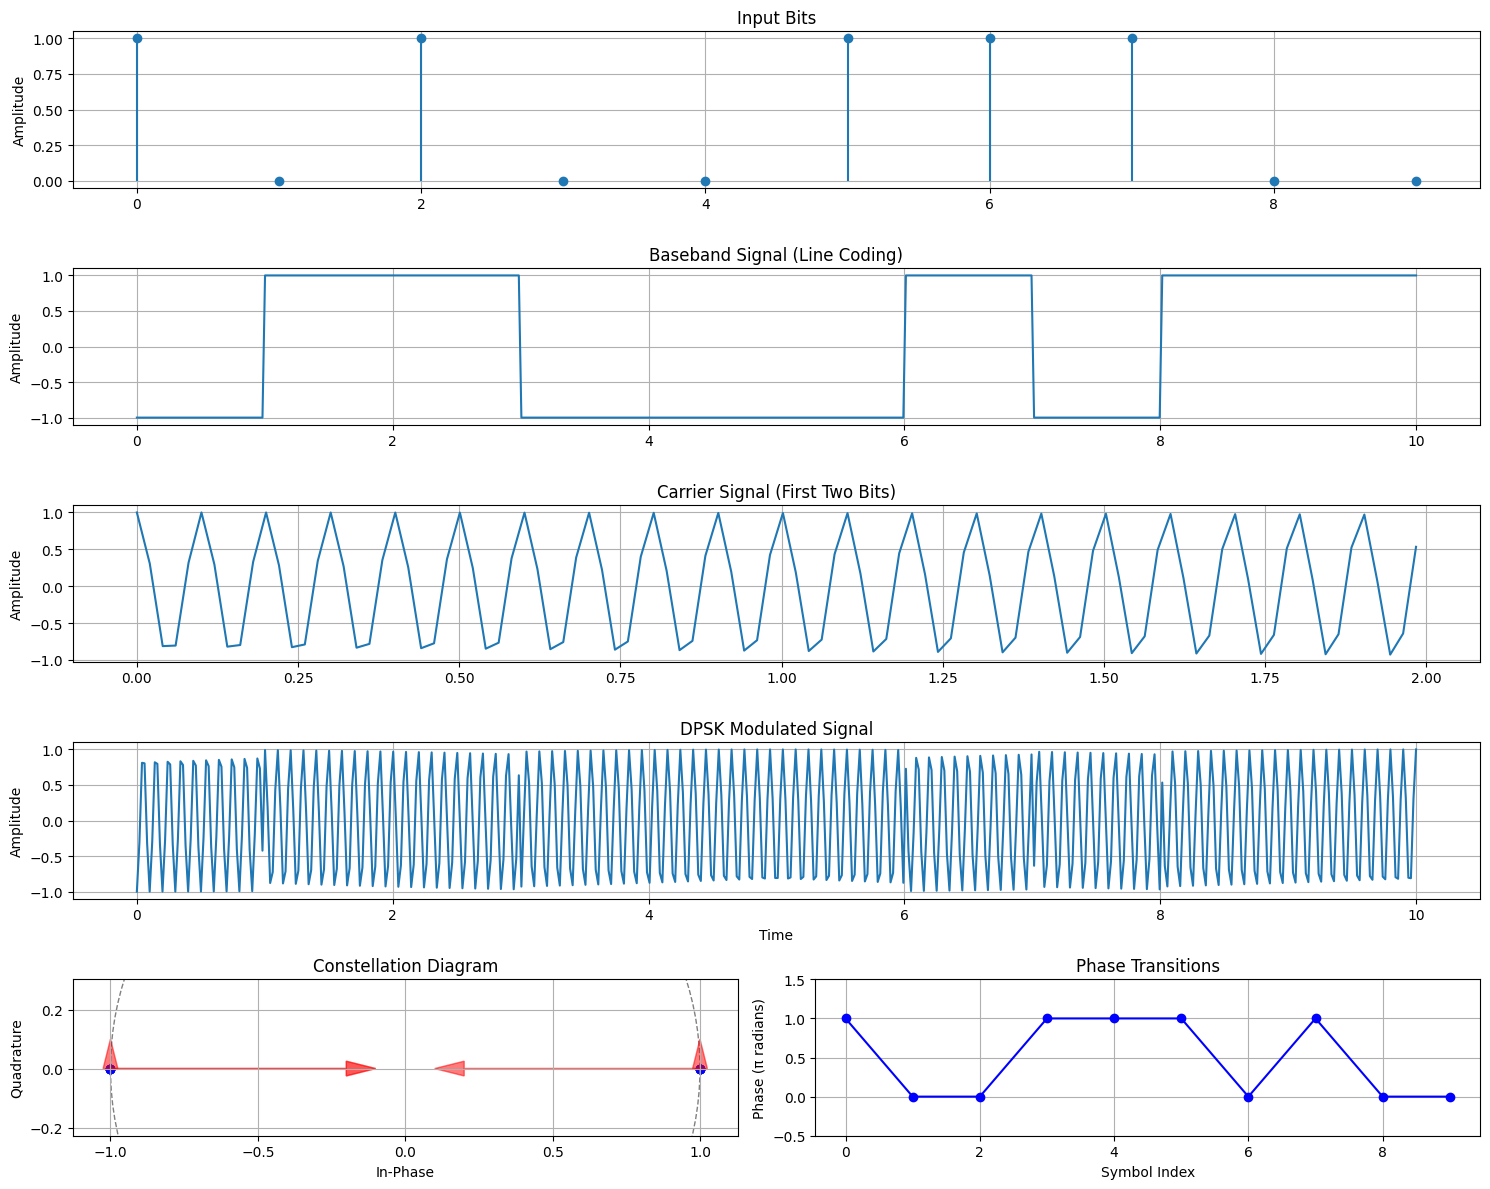

In [3]:
# Example usage
if __name__ == "__main__":
    # Example from the image
    bits = [1, 0, 1, 0, 0, 1, 1, 1, 0, 0]

    # Create DPSK processor and process bits
    dpsk = DPSKProcess(bits)
    results = dpsk.process_dpsk()

    # Display numerical results
    dpsk.display_results(results)

    # Plot signals
    fig = dpsk.plot_signals(results)
    plt.show()